In [1]:
import json
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import torch
from datetime import datetime , date, timedelta

In [2]:
dates = np.empty(0)
repos = np.empty(0)

In [3]:
f_list = [
    'data/cleaned/NKY/Repo/repo_schedule_NKY_from_20130101_to_20190726.json',
    'data/cleaned/SPX/Repo/repo_schedule_SPX_from_20130101_to_20190726.json',
    'data/cleaned/SX5E/Repo/repo_schedule_SX5E_from_20130101_to_20190726.json',
    'data/cleaned/UKX/Repo/repo_schedule_UKX_from_20130101_to_20190726.json',
]

In [4]:
for f_ in f_list:
    with open(f_, 'r') as f:
        dictionary = json.load(f)

    new_dict = {}
    for key in list(dictionary.keys()):
        if (dictionary[key] != None):
            if np.sum(np.isnan(dictionary[key][0])) == 0 and np.sum(
                    np.isnan(list(map(float, dictionary[key][1])))) == 0:
                dictionary[key][1] = list(map(float, dictionary[key][1]))
                new_dict[key] = dictionary[key]

    indices = list(new_dict.keys())
    dates = np.hstack([dates, np.array(list(new_dict.values()))[:, 0]])
    repos = np.hstack([repos, np.array(list(new_dict.values()))[:, 1]])

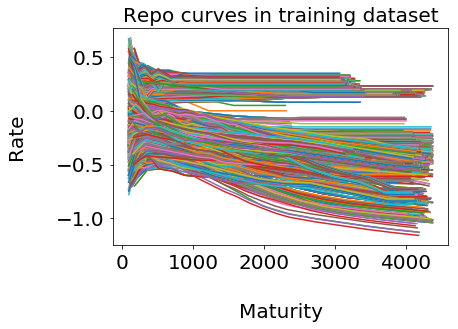

In [5]:
for date, repo in zip(dates, repos):
    #     print(len(date),len(repo))
    plt.plot(np.array(date)[(np.array(date)>=90) & (np.array(date)<=4380)], np.array(repo)[(np.array(date)>=90) & (np.array(date)<=4380)])
plt.xlabel("Maturity", fontsize=20, labelpad=30)
plt.ylabel("Rate", fontsize=20, labelpad=30)
plt.tick_params(axis='x', labelsize=20, pad=5)
plt.tick_params(axis='y', labelsize=20, pad=5)
plt.title("Repo curves in training dataset", fontsize = 20)
plt.show()

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:

class AE(nn.Module):
    def __init__(self):
        super(AE, self).__init__()

        self.linear1 = nn.Linear(5, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        x = self.linear3(x)
        return x

In [8]:
class Attrib(nn.Module):
    def __init__(self):
        super(Attrib, self).__init__()
        self.attrib = nn.Parameter(torch.zeros([2645, 4]), requires_grad=True)

    def forward(self, x):
        return self.attrib


In [9]:

n = len(dates)
ae = AE()
attrib = Attrib()

optimizer = torch.optim.Adam(list(ae.parameters()) + list(attrib.parameters()), lr=1e-2)

In [10]:
for _ in range(10000):

    res = torch.Tensor([0.])
    for __ in range(50):
        k = np.random.choice(n)
        res_ = []
        for x, y in zip(dates[k], repos[k]):
            if x > 90:
                res_.append((ae(torch.cat([torch.Tensor([x / 252.0]), attrib.attrib[k, :]]))[0] - y) ** 2)
        res += torch.mean(torch.stack(res_))

    res += torch.mean(torch.mean(attrib.attrib))**2 + (torch.mean(torch.mean(attrib.attrib**2))-1)**2
    optimizer.zero_grad()
    res.backward()
    optimizer.step()
    if _ % 100 == 0:
        print(res.detach().numpy()[0])


9.31417
2.51476
1.58273
1.27008
0.825976
0.592752
0.488317
0.610357
0.389054
0.346013
0.26152
0.253651
0.255045
0.239209
0.229082
0.186547
0.187505
0.179396
0.153606
0.123927
0.153353
0.129937
0.100522
0.12149
0.106715
0.094705
0.0693459
0.0766923
0.0785757
0.067059
0.0673245
0.0955384
0.0899913
0.146469
0.079368
0.0777495
0.0434874
0.0452292
0.0552184
0.0582171
0.0483499
0.07121
0.04281
0.0594581
0.0419837
0.0354662
0.0449818
0.0403778
0.0471466
0.0370276
0.0592229
0.0394169
0.0436259
0.056969
0.0727843
0.037296
0.0427968
0.0487516
0.0367607
0.0319698
0.0390258
0.0310462
0.034086
0.0383323
0.0467326
0.0647697
0.0416317
0.0431344
0.0381891
0.025986
0.0324873
0.0403718
0.0389692
0.0388296
0.0369428
0.0315034
0.0442619
0.0515042
0.0417855
0.0375848
0.0413544
0.0412594
0.0594192
0.0433107
0.0368533
0.0321646
0.0294211
0.0289995
0.0340777
0.0609281
0.0378037
0.0339153
0.038589
0.0390353
0.0232052
0.0372183
0.0365586
0.0258677
0.0637206
0.0491323


In [35]:
def plotCurve(dataSerieOriginal, dataSerieInterpolated, title):
    refSize=5
    plt.plot(dataSerieOriginal, 'o')
    plt.plot(dataSerieInterpolated)
    plt.xlabel("Maturity (Year)", fontsize=2*refSize, labelpad=3*refSize)
    plt.ylabel("Rate (%)", fontsize=2*refSize, labelpad=3*refSize)
    plt.tick_params(axis='x', labelsize=2*refSize, pad=int(refSize/2))
    plt.tick_params(axis='y', labelsize=2*refSize, pad=int(refSize/2))
    plt.title(title, fontsize = 2*refSize)
    plt.show()

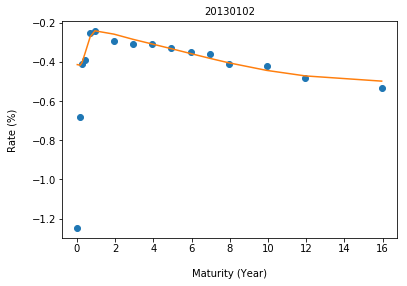

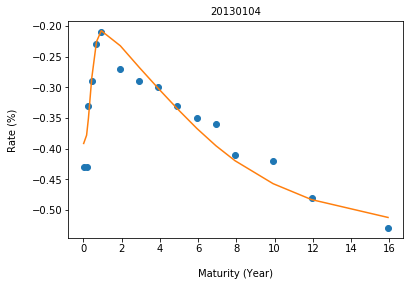

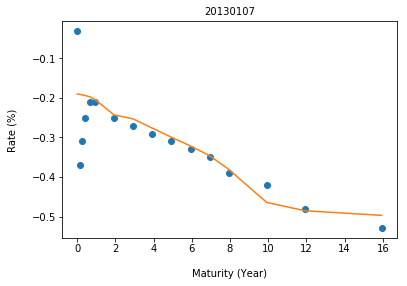

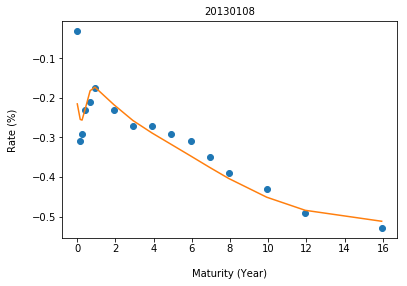

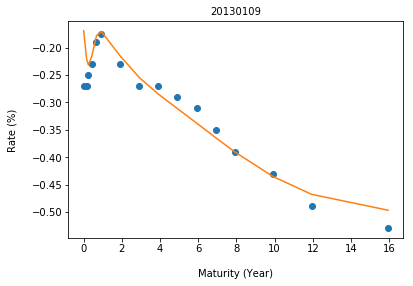

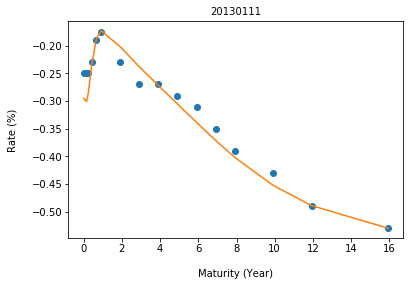

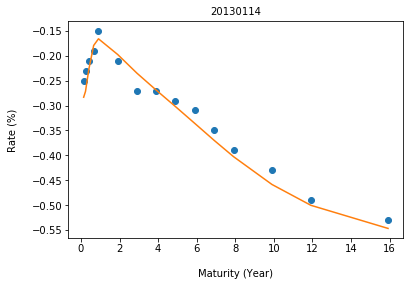

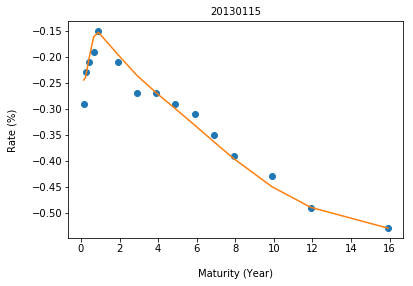

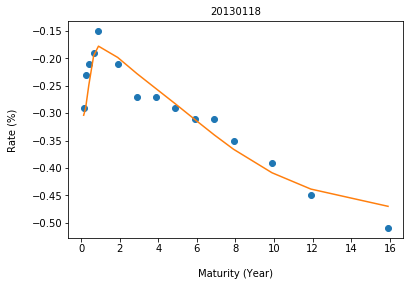

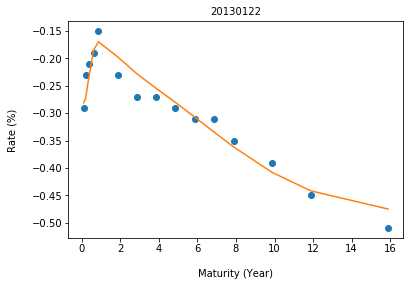

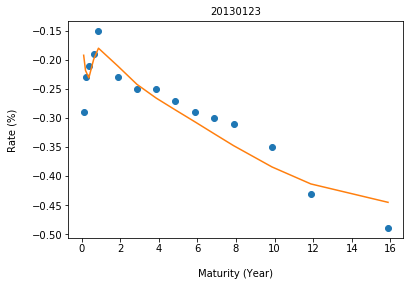

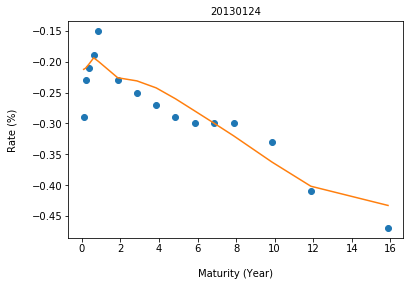

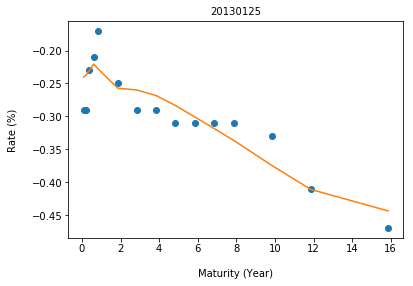

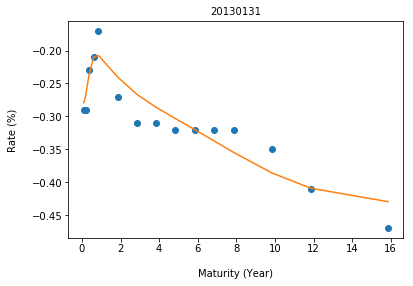

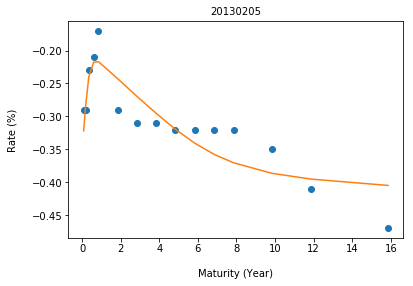

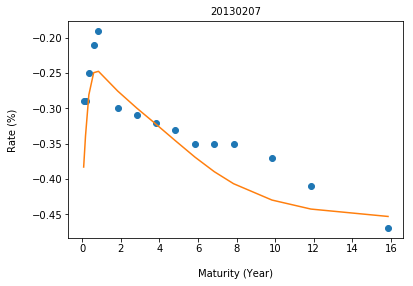

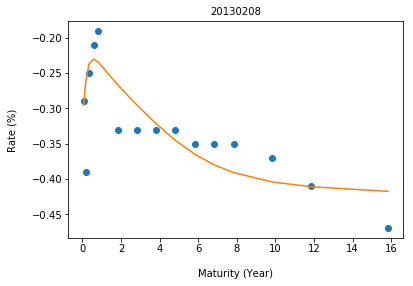

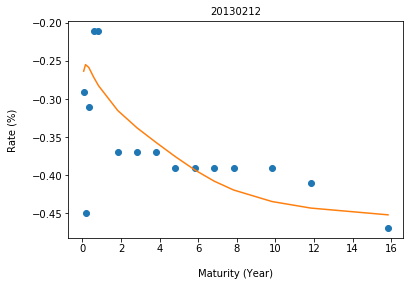

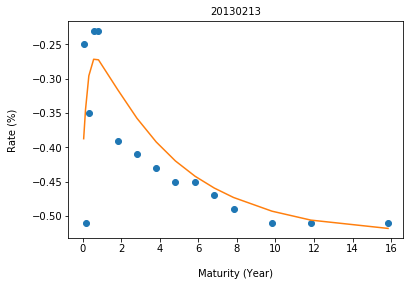

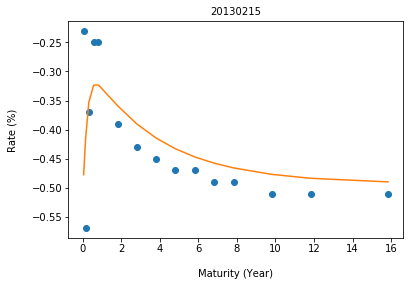

In [36]:
for k in range(20):
    date = dates[k]
    repo = repos[k]
    pred = []
    for x in date:
        pred.append((ae(torch.cat([torch.Tensor([x / 252.0]), attrib.attrib[k, :]])).detach().numpy())[0])
    #plt.figure()
    #plt.plot(date, pred)
    #plt.plot(date, repo, 'o')
    #plt.title(indices[k])
    plotCurve(pd.Series(repo, index=list(map(lambda x : x/365,date))),
              pd.Series(pred, index=list(map(lambda x : x/365,date))),
              indices[k])
    #plt.show()

In [37]:
# saving model
torch.save(ae.state_dict(),
           'model_objects/jiang_state_dict_model.pth')
torch.save(ae,
           'model_objects/jiang_full_model.pth')

C:\ProgramData\Anaconda3\lib\site-packages\torch\serialization.py:193: UserWarning: Couldn't retrieve source code for container of type AE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [38]:
def loss(s1, s2):
    return np.mean((s1-s2)**2)**(0.5)

In [39]:
formattedIndices = [datetime.strptime(d , '%Y%m%d') for d in indices ]

In [58]:
formattedIndices

[datetime.datetime(2013, 1, 2, 0, 0),
 datetime.datetime(2013, 1, 4, 0, 0),
 datetime.datetime(2013, 1, 7, 0, 0),
 datetime.datetime(2013, 1, 8, 0, 0),
 datetime.datetime(2013, 1, 9, 0, 0),
 datetime.datetime(2013, 1, 11, 0, 0),
 datetime.datetime(2013, 1, 14, 0, 0),
 datetime.datetime(2013, 1, 15, 0, 0),
 datetime.datetime(2013, 1, 18, 0, 0),
 datetime.datetime(2013, 1, 22, 0, 0),
 datetime.datetime(2013, 1, 23, 0, 0),
 datetime.datetime(2013, 1, 24, 0, 0),
 datetime.datetime(2013, 1, 25, 0, 0),
 datetime.datetime(2013, 1, 31, 0, 0),
 datetime.datetime(2013, 2, 5, 0, 0),
 datetime.datetime(2013, 2, 7, 0, 0),
 datetime.datetime(2013, 2, 8, 0, 0),
 datetime.datetime(2013, 2, 12, 0, 0),
 datetime.datetime(2013, 2, 13, 0, 0),
 datetime.datetime(2013, 2, 15, 0, 0),
 datetime.datetime(2013, 2, 19, 0, 0),
 datetime.datetime(2013, 2, 22, 0, 0),
 datetime.datetime(2013, 2, 25, 0, 0),
 datetime.datetime(2013, 2, 27, 0, 0),
 datetime.datetime(2013, 3, 1, 0, 0),
 datetime.datetime(2013, 3, 4, 0, 

In [40]:
def evaluateTrainingSet(dates, repos):
    preds = {}
    originalSerie = {}
    rmses = []
    for k in range(len(formattedIndices)):
        date = list(filter(lambda x: x >= 90, dates[k]))
        repo = [repos[k][x] for x in range(len(dates[k])) if 90 <= dates[k][x]]
        pred = []
        for x in date:
            pred.append((ae(torch.cat([torch.Tensor([x / 252.0]), 
                                       attrib.attrib[k, :]])).detach().numpy())[0])
        
        repoSeries = pd.Series(repo,index = list(map(lambda x : x/365, date))).sort_index()
        originalSerie[formattedIndices[k]] = repoSeries
        
        predSeries = pd.Series(pred,index = list(map(lambda x : x/365, date))).sort_index()
        preds[formattedIndices[k]] = predSeries
        
        rmses.append(loss(np.array(pred), np.array(repo)))
    
    rmseSeries = pd.Series(rmses,index = formattedIndices).sort_index()
    return preds,originalSerie,rmseSeries

In [41]:
interpolatedPoints, realPoints, dailyLoss = evaluateTrainingSet(dates, repos)

In [42]:
inLiers = list(filter(lambda x: dailyLoss[x] <= 0.005, formattedIndices))

In [43]:
outLiers = list(filter(lambda x: dailyLoss[x] >= 0.035, formattedIndices))

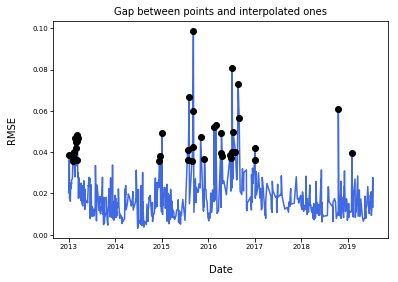

In [44]:
refFontSize=5
plt.plot(dailyLoss, color='royalblue')
plt.plot(dailyLoss.loc[outLiers], 'o', color='k')
plt.xlabel("Date", fontsize=2*refFontSize, labelpad=3*refFontSize)
plt.ylabel("RMSE", fontsize=2*refFontSize, labelpad=3*refFontSize)
plt.tick_params(axis='x', labelsize=int(3*refFontSize/2), pad=int(refFontSize/2))
plt.tick_params(axis='y', labelsize=int(3*refFontSize/2), pad=int(refFontSize/2))
plt.title("Gap between points and interpolated ones", fontsize = 2*refFontSize)
plt.show()

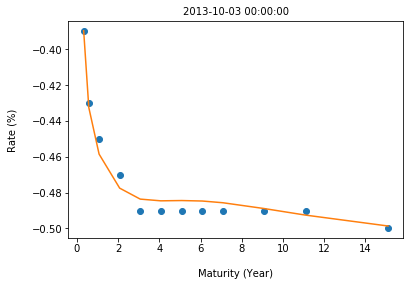

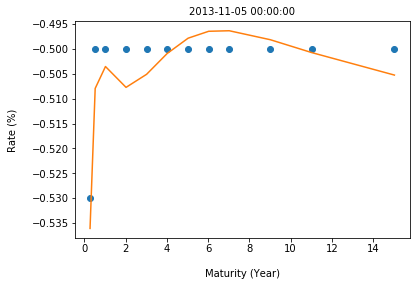

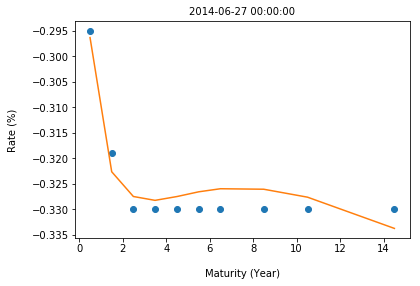

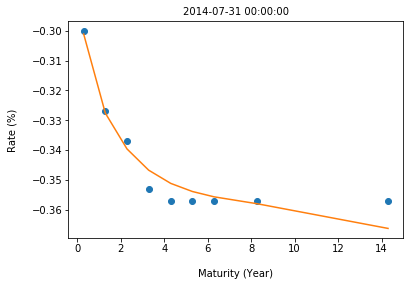

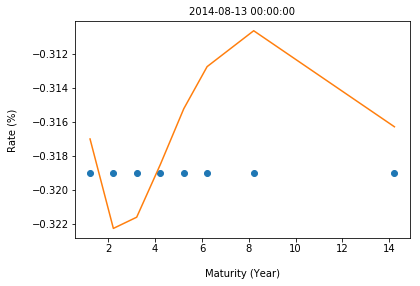

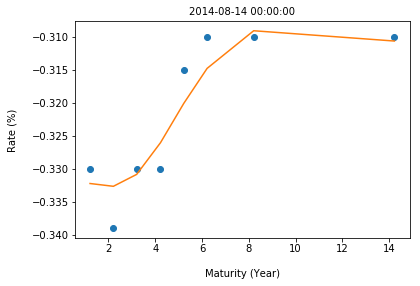

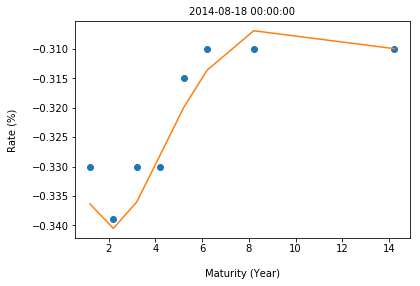

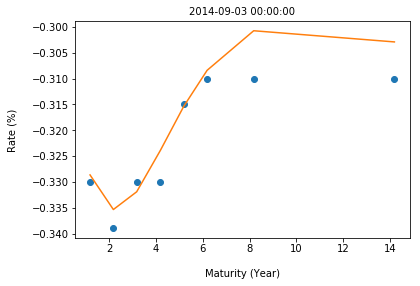

In [50]:
for k in inLiers:
    plotCurve(realPoints[k],interpolatedPoints[k],k)

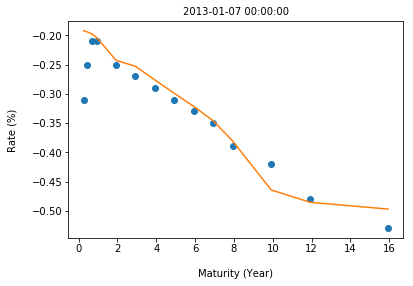

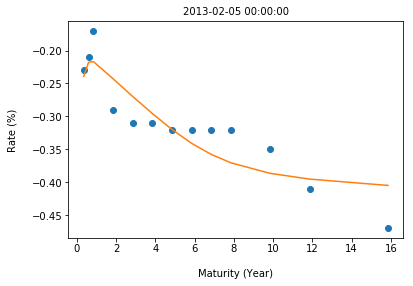

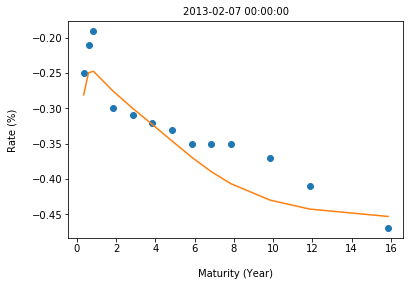

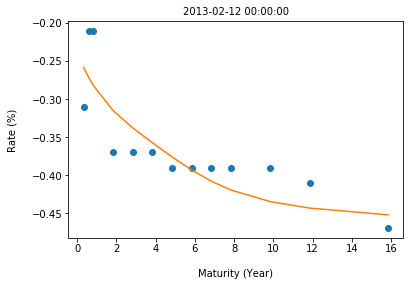

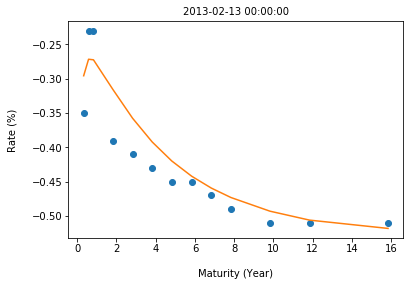

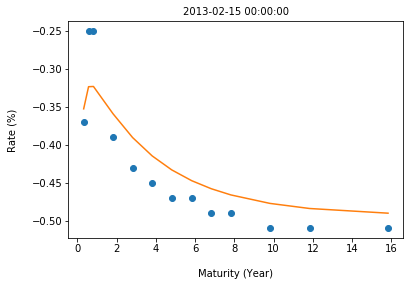

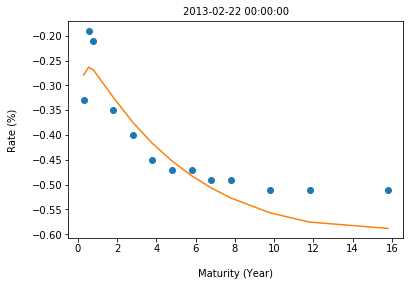

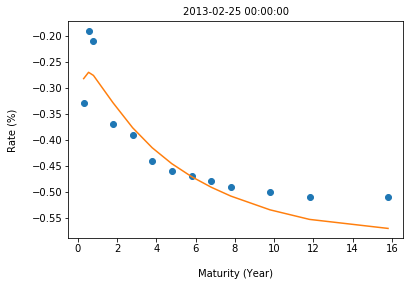

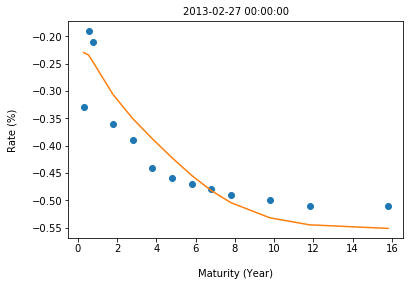

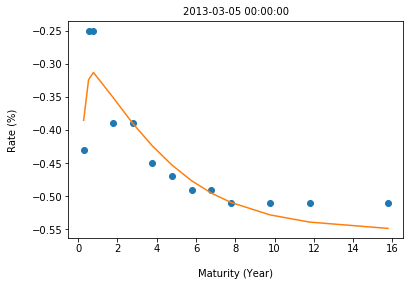

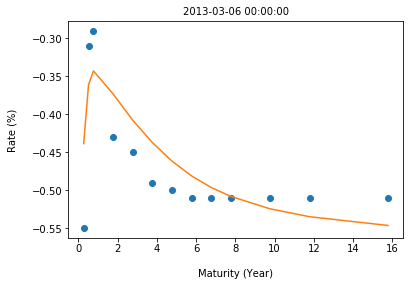

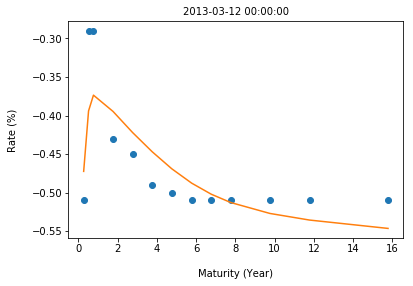

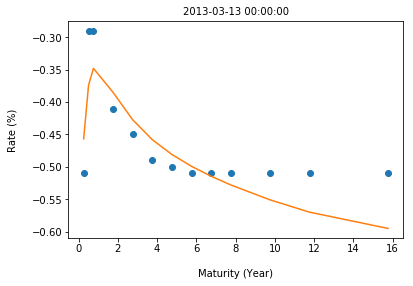

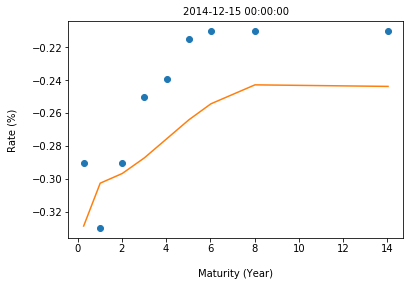

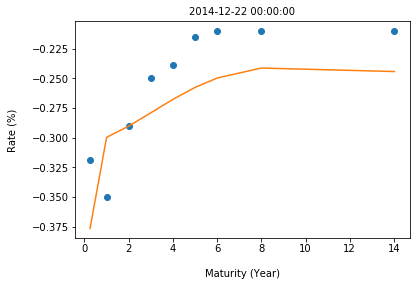

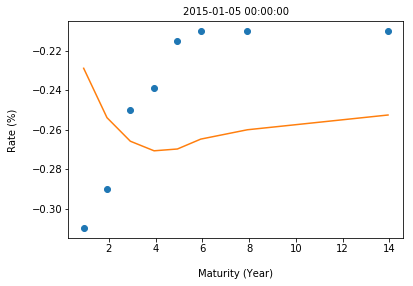

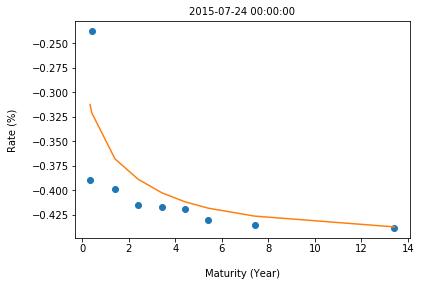

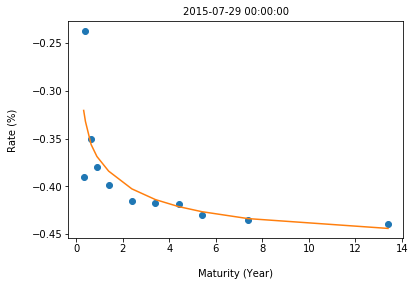

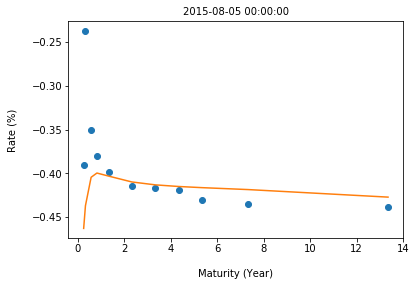

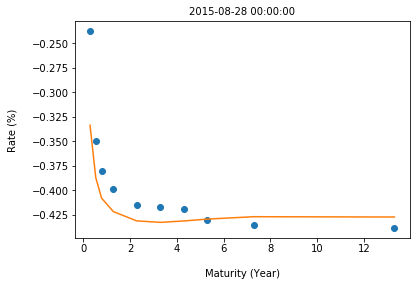

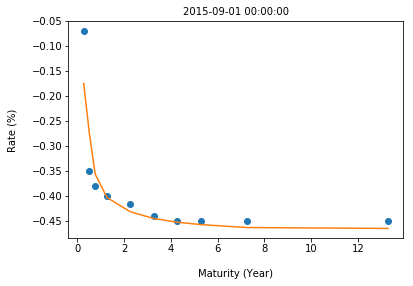

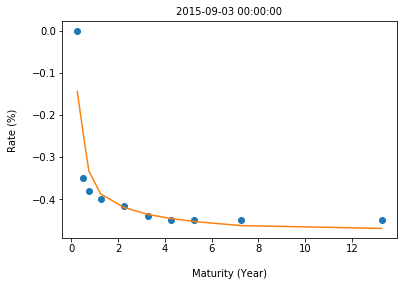

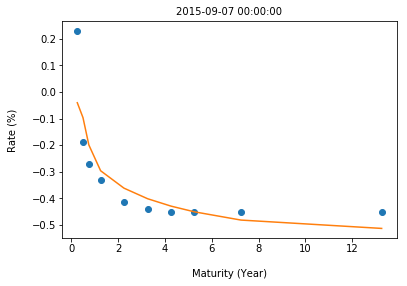

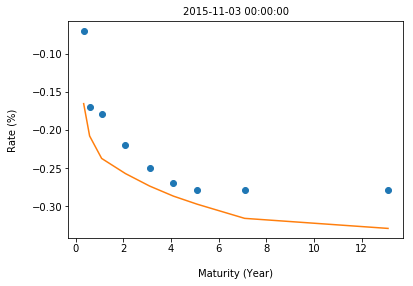

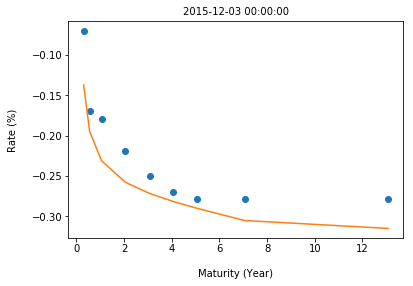

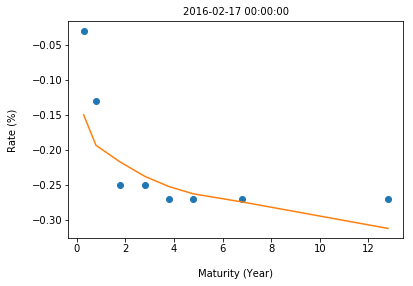

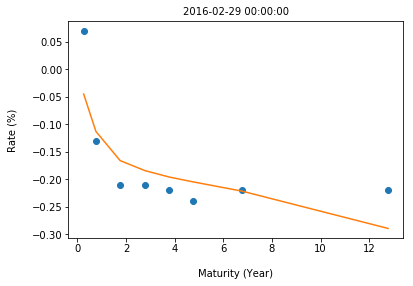

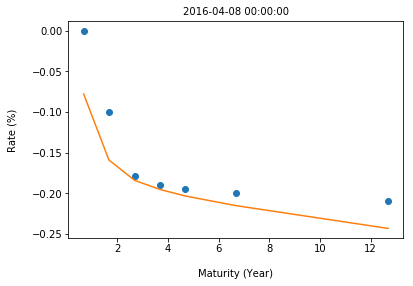

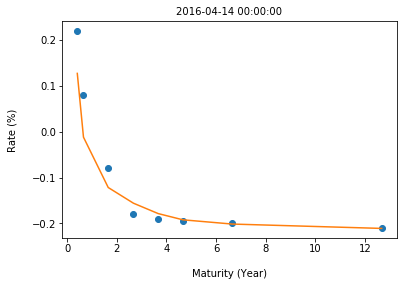

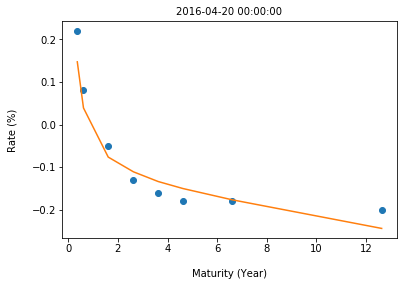

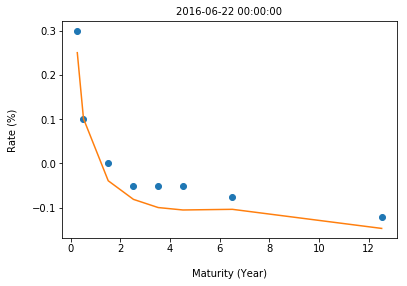

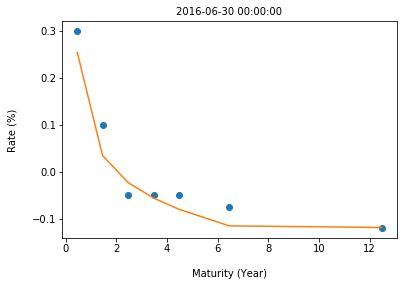

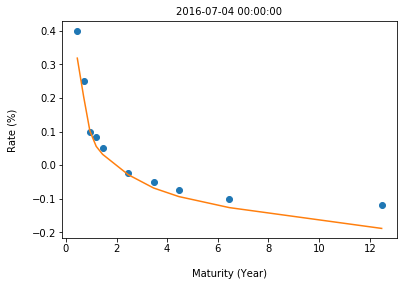

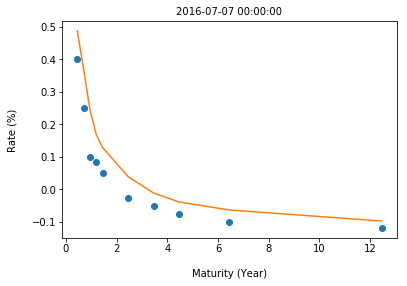

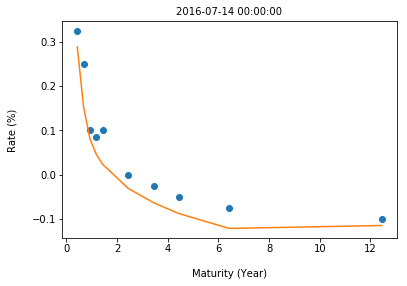

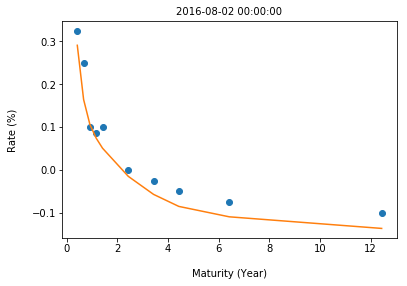

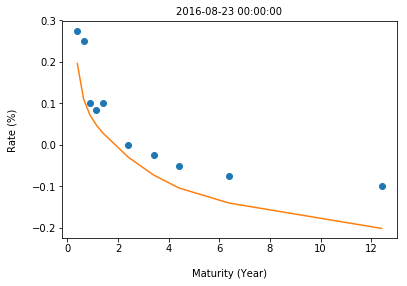

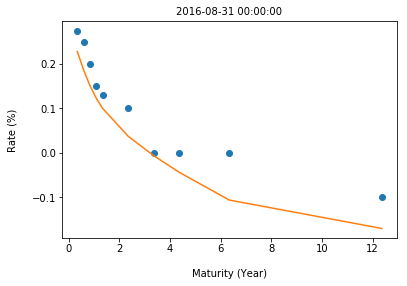

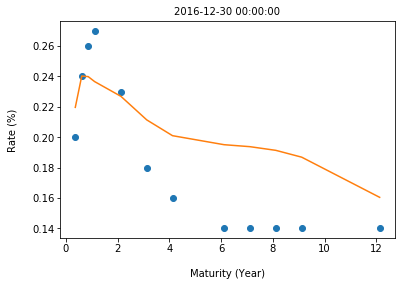

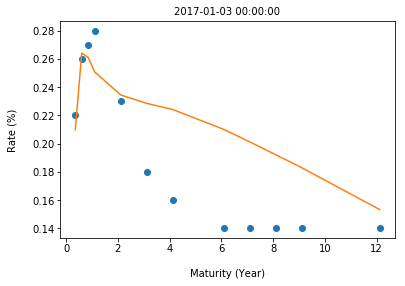

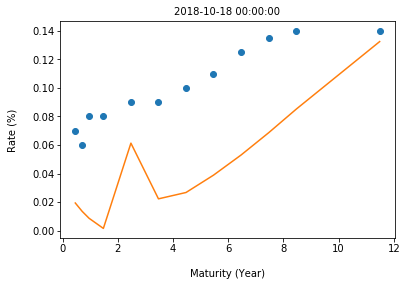

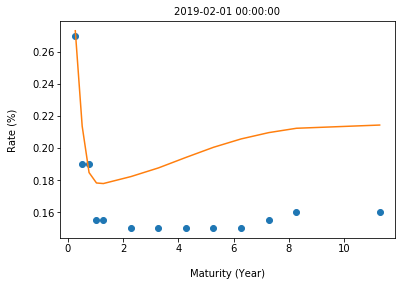

In [51]:
for k in outLiers:
    plotCurve(realPoints[k],interpolatedPoints[k],k)

In [55]:
ind3 = inLiers[0]
interpolatedPoints[ind3]

0.334247    -0.389610
0.583562    -0.432510
1.082192    -0.458510
2.079452    -0.477504
3.076712    -0.483631
4.073973    -0.484594
5.090411    -0.484436
6.087671    -0.484704
7.084932    -0.485662
9.076712    -0.488890
11.093151   -0.492566
15.093151   -0.498653
dtype: float64

In [56]:
realPoints[ind3]

0.334247    -0.39
0.583562    -0.43
1.082192    -0.45
2.079452    -0.47
3.076712    -0.49
4.073973    -0.49
5.090411    -0.49
6.087671    -0.49
7.084932    -0.49
9.076712    -0.49
11.093151   -0.49
15.093151   -0.50
dtype: float64

In [57]:
ind3

datetime.datetime(2013, 10, 3, 0, 0)